In [11]:
import numpy as np

import pennylane as qml

from matplotlib import pyplot as plt

In [12]:
dev = qml.device("default.qubit", wires=1)

In [13]:
def plot_bloch_sphere():
    # plot the path on Bloch sphere!
    u = np.linspace(0, np.pi, 31)
    v = np.linspace(0, 2 * np.pi, 30)

    bloch_x = np.outer(np.sin(u), np.sin(v))
    bloch_y = np.outer(np.sin(u), np.cos(v))
    bloch_z = np.outer(np.cos(u), np.ones_like(v))

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_wireframe(bloch_x, bloch_y, bloch_z, color='k',alpha=0.1)
    ax.plot(np.cos(v), np.sin(v), 0, color='k', alpha=0.2)
    ax.set_box_aspect([1,1,1])
    ax.azim += 90
    plt.axis('off')

    # Make a 3D quiver plot
    x, y, z = np.zeros((3,3))
    u, v, w = np.array([[1.3,0,0],[0,1.3,0],[0,0,1.3]])

    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color='k')

    plt.tight_layout(pad=0.1)

    return ax

In [14]:
""" Circuit we are optimising
Rotations first create the initial state.
Then we optimise the angles to rotate to the target state.
"""

@qml.qnode(dev)
def Rotation_circuit(initial, thetas):

    # creates the initial state
    qml.RY(initial[0], wires=0)
    qml.RZ(initial[1], wires=0)

    # general rotation
    qml.RZ(thetas[0], wires=0)
    qml.RY(thetas[1], wires=0)
    qml.RZ(thetas[2], wires=0)

    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))

In [15]:
# this is our "loss function"
def distance(vector, expectations):
    return np.sqrt(np.sum((np.array(vector) - np.array(expectations))**2))

In [16]:
initial = np.array([0.3*np.pi,0])  # initial angles
target_vector = np.random.randn(3)  # random target Bloch vector
target_vector = target_vector / np.sqrt(np.vdot(target_vector,target_vector))

initial_vector = Rotation_circuit(initial, [0,0,0])  # get initial Bloch vector corresponding to the initial angles

print(initial_vector)
print(target_vector)
print(distance(target_vector, initial_vector))

(0.8090169943749471, 0.0, 0.5877852522924732)
[-0.69061386 -0.71725117  0.09275375]
1.734473441289471


In [17]:
c = 0.1
eta = 0.1

n_iterations = 50

thetas = np.array([0,0,0])  # initial angles set to zero
initial_vector = Rotation_circuit(initial, [0,0,0])  # get initial Bloch vector corresponding to the initial angles
vector_list = [initial_vector]  # store the vectors as we go
distance_list = [distance(target_vector, initial_vector)]  # store distances with each iteration for plotting

for jj in range(n_iterations):

    grad = [0,0,0]
    for ii in range(3):
        e_vec = np.array([0,0,0])  # vector to perturb ith component
        e_vec[ii] = 1
        theta_plus = thetas + c*e_vec
        theta_minus = thetas - c*e_vec

        vec_plus = Rotation_circuit(initial, theta_plus)
        vec_minus = Rotation_circuit(initial, theta_minus)

        d_plus = distance(target_vector, vec_plus)
        d_minus = distance(target_vector, vec_minus)

        grad[ii] = (d_plus - d_minus) / (2*c)  # second-order approximate gradient

    thetas = thetas.copy() - eta*np.array(grad)  # gradient descent step

    vector_list.append(Rotation_circuit(initial, thetas))
    distance_list.append(distance(target_vector, vector_list[-1]))


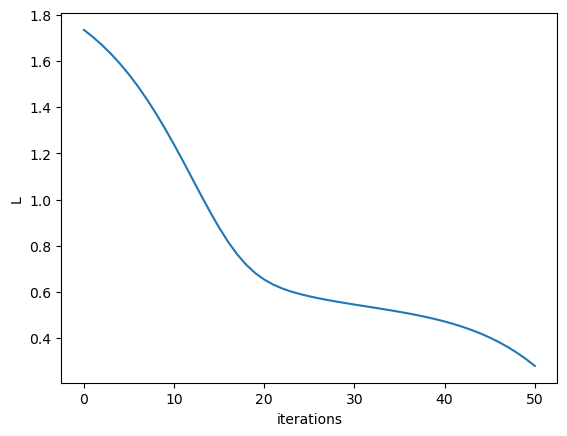

In [18]:
plt.plot(distance_list)
plt.xlabel("iterations")
plt.ylabel("L")

#plt.savefig("OptimisationLoss.pdf", format="pdf", bbox_inches="tight")  # save figure to pdf
plt.show()

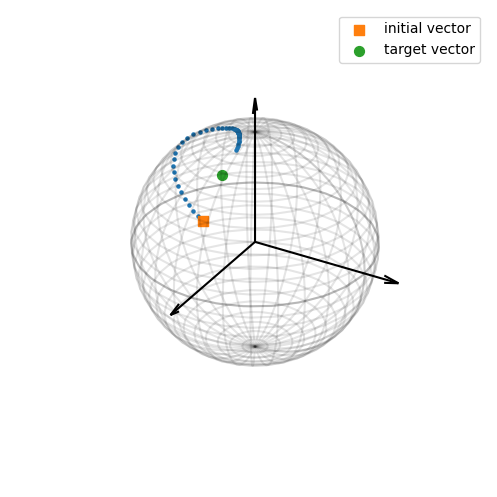

In [19]:
ax = plot_bloch_sphere()

for vector in vector_list:
    ax.scatter(vector[0], vector[1], vector[2], marker='.', c="C0")  # Bloch vector for each iteration

ax.scatter(vector_list[0][0], vector_list[0][1], vector_list[0][2], marker='s', s=50, c="C1", label="initial vector")
ax.scatter(target_vector[0], target_vector[1], target_vector[2], marker='o', s=50, c="C2", label="target vector")

plt.legend()
#plt.savefig("BlochSphereOptimisation.pdf", format="pdf", bbox_inches="tight")  # save figure to pdf
plt.show()

In [20]:
print(thetas)

[-1.79390669 -0.67937493 -0.30440022]
